In [1]:
# Imports
import numpy as np
from numpy.lib.arraysetops import unique
from scipy.sparse import lil_matrix, csr_matrix, bmat
from scipy.sparse import linalg 
from scipy.sparse.linalg import spsolve

In [2]:
# Import repository
! rm -fr *
! git clone https://gitlab.com/jan.zeman4/d32mhm2_en.git tmp
! mv tmp/* . # copy to current directory
! rm -fr tmp/ # cleanup

Cloning into 'tmp'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 81 (delta 41), reused 50 (delta 23), pack-reused 0
Unpacking objects: 100% (81/81), done.


In [3]:
# Local functions
from show import show
from data import u_D_hmg 
from stima import stima3_hmg, rhs3_hmg 

In [4]:
# Load all data
coordinates = np.loadtxt ( 'coordinates_hmg.dat', comments = '%' )
elements3 = np.loadtxt( 'elements3_hmg.dat', dtype = 'int', comments = '%' )
dirichlet = np.loadtxt( 'dirichlet_hmg.dat', dtype = 'int', comments = '%' )
# New data needed for homogenization
phases = np.loadtxt ( 'phases_hmg.dat', comments = '%' )
periodicity = np.loadtxt ( 'periodicity_hmg.dat', dtype = 'int', comments = '%' )

In [5]:
# delete first columns from coordinates, elements3, elements4, and neumann arrays
coordinates = np.delete( coordinates, 0, 1 )
elements3 = np.delete( elements3, 0, 1 )
dirichlet = np.delete( dirichlet, 0, 1 )
phases = np.delete( phases, 0, 1 )
periodicity = np.delete( periodicity, 0, 1 )

In [6]:
# setup matrices
FreeNodes = np.setdiff1d( range( coordinates.shape[0]), np.unique( dirichlet ) )
A = lil_matrix( np.zeros( (coordinates.shape[0], coordinates.shape[0]) ) ) 
b = np.zeros( (coordinates.shape[0], 1) )  
u = np.zeros( (coordinates.shape[0], 1) ) 

In [7]:
E = np.array([ [0], [1] ])

for j in range( elements3.shape[0] ):
   A[ np.ix_( elements3[j, 0:3], elements3[j, 0:3] ) ] += stima3_hmg( coordinates[ elements3[j, 0:3], ], phases[ elements3[j, 3], ] )
   b[ elements3[j, 0:3] ] += rhs3_hmg( coordinates[ elements3[j, 0:3], ], phases[ elements3[j, 3], ], E )

In [8]:
# Prepare tying matrix T
T = np.zeros( (periodicity.shape[0], coordinates.shape[0]) )

for j in range( periodicity.shape[0] ):
  T[j, periodicity[j, :]] = [1, -1] 

In [11]:
# Setup the partitioned system
A_hmg = bmat( [ [ A[ np.ix_( FreeNodes, FreeNodes) ], T[:, FreeNodes ].transpose() ], \
  [ T[:, FreeNodes ], None ] ] )
b_hmg = np.block( [ [ b[ FreeNodes, ] ], [ np.zeros( ( T.shape[0], 1 ) ) ] ] )

u_hmg = spsolve( A_hmg.tocsr(), b_hmg ) # Solve the partitioned system

u[ (FreeNodes, 0) ] = u_hmg[ 0:FreeNodes.shape[0] ]

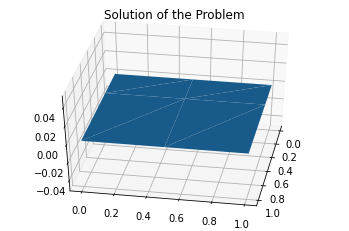

In [12]:
# Setup the partitioned system
show(elements3[:, 0:3], np.array([]), coordinates, u)